In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact, yeojohnson
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, pearsonr
from sklearn.linear_model import LinearRegression
from bioinfokit import analys, visuz
from qqman import qqman

# GWAS results from Encore - Old 

- Ran 2 analyses:
    1. Response variable = total passenger mutations; covariates = sex, age, PCs 1-10; variant filter = MAF > 0.1%
    2. Response variable = pacer_covadj_int; covariates = PCs 1-10; variant filter = MAF > 0.1%


- Model: Fast linear mixed model with kinship adjustment (saige-qt)

- Goal: To determine germline mutations associated with higher fitness (# of passenger mutations) among patients with mCAs

In [2]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/adc7c434-output.filtered.001 .

In [3]:
# gwas_results_totpassmut_df = pd.read_csv('adc7c434-output.filtered.001', sep='\t')

In [4]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/a9b9a820-output.filtered.001 .

In [5]:
# gwas_results_pacerint_df = pd.read_csv('a9b9a820-output.filtered.001', sep='\t')

# GWAS results from Encore - New

- Response variable = total passenger mutations; covariates = sex, age, CHIP status, clonal fraction, PCs 1-10, status; variant filter = MAF > 0.1%

- Model: Fast linear mixed model with kinship adjustment (saige-qt)

- Goal: To determine germline mutations associated with higher fitness (# of passenger mutations) among patients with mCAs

In [6]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/54283d8c-output.filtered.001 .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/54283d8c-output.filtered.001...
/ [1 files][  4.6 MiB/  4.6 MiB]                                                
Operation completed over 1 objects/4.6 MiB.                                      


In [7]:
gwas_results_totpassmut_df = pd.read_csv('54283d8c-output.filtered.001', sep='\t')

## Exclude variants w AF < 0.01

In [8]:
gwas_results_totpassmut_df = gwas_results_totpassmut_df[gwas_results_totpassmut_df['AF_Allele2'] > 0.01]

## Excluding chrX

In [9]:
def exclude_chrX(df):
    print(len(df)-len(df[df['CHR']!='chrX']))
    return df[df['CHR']!='chrX']

In [10]:
gwas_results_pacerint_df = exclude_chrX(gwas_results_totpassmut_df)

963


In [11]:
gwas_results_pacerint_df['CHR'] = gwas_results_pacerint_df['CHR'].str.replace("chr", "")
gwas_results_pacerint_df['ind'] = range(len(gwas_results_pacerint_df))
gwas_results_pacerint_df['-logp'] = -np.log10(gwas_results_pacerint_df['p.value'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

# Manhattan Plots

In [12]:
def manhattanplot(df, filename):
    fig = plt.figure(figsize=(25, 15)) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['darkred','darkgreen','darkblue', 'gold']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df.groupby('CHR')):
        group.plot(kind='scatter', x='ind', y='-logp',color='gray', ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
            
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, fontsize=17)

    # set axis limits
    # ax.set_xlim([0, len(df)])
    ax.set_ylim([3, 9])
    ax.tick_params(axis='y', which='major', labelsize=30)
    plt.axhline(-np.log10(5e-8), ls='--', c='red')

    # x axis label
    ax.set_xlabel('Chr', fontsize = 30)
    ax.set_ylabel('-log(p-value)', fontsize=30)

    plt.savefig(filename, dpi=300)
    
    plt.show()

In [13]:
# def manhattanplot(df):
#     df['-logp'] = - np.log10(df['p.value'])
#     running_pos = 0
#     cumulative_pos = []
#     for chrom, group_df in df.groupby('CHR'):  
#         cumulative_pos.append(group_df['POS'] + running_pos)
#         running_pos += group_df['POS'].max()
#     df['cumulative_pos'] = pd.concat(cumulative_pos)
#     df['SNP number'] = df.index
#     g = sns.relplot(
#         data = df,
#         x = 'cumulative_pos',
#         y = '-logp',
#         aspect = 4,
#         hue = 'CHR',
#         palette = ['grey', 'black'] * 11,
#         linewidth=0,
#         s=6,
#         legend=None
#     )
#     plt.axhline(-np.log10(5e-8), ls='--', c='red')
#     g.ax.set_ylabel('-log(p)', fontsize=20)
#     g.ax.set_ylim(3, 8)
#     g.ax.tick_params(axis='y', which='major', labelsize=20)
#     g.ax.set_xlabel('Chromosome', fontsize=20)
#     g.ax.set_xticks(df.groupby('CHR')['cumulative_pos'].median())
# #     g.ax.set_xticklabels(df['CHR'].str.replace("chr", "").unique(), fontsize=12)
#     g.ax.set_xticklabels(df['CHR'].str.replace("chr", "").unique(), fontsize=12)

# #     g.fig.suptitle('Manhattan Plot for GWAS of PACER among pts with mCAs', fontsize=30)
#     g.fig.set_size_inches(18.5, 10.5)

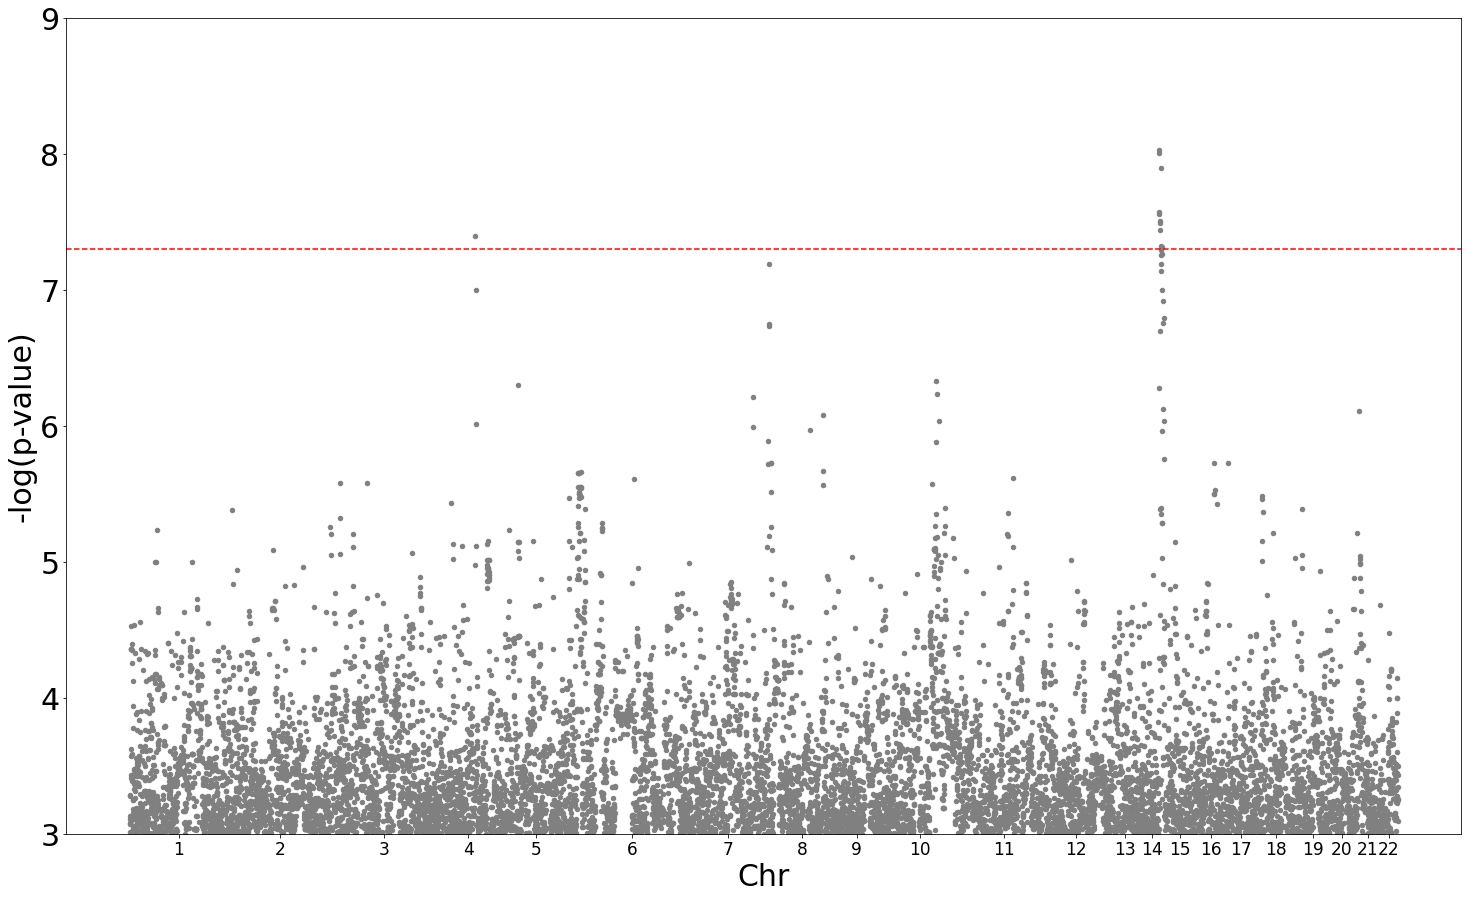

In [14]:
manhattanplot(gwas_results_pacerint_df, 'fig3a_pacergwas_withchip.tif') #cov-adjusted during GWAS

In [15]:
! gsutil cp fig3a_pacergwas_withchip.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig3a_pacergwas_withchip.tif

Copying file://fig3a_pacergwas_withchip.tif [Content-Type=image/tiff]...
\ [1 files][128.8 MiB/128.8 MiB]                                                
Operation completed over 1 objects/128.8 MiB.                                    


In [16]:
gwas_results_totpassmut_df.sort_values('p.value', ascending = True)

,CHR,POS,SNPID,Allele1,Allele2,AC_Allele2,AF_Allele2,imputationInfo,N,BETA,SE,Tstat,p.value,varT,varTstar
21628,chr14,95713905,rs1122138,C,A,2950,0.211197,1,6984,-0.102036,0.017770,-323.143000,9.348600e-09,3166.952485,2185.177273
21627,chr14,95711986,rs2296312,T,C,2964,0.212199,1,6984,-0.101648,0.017728,-323.447042,9.813428e-09,3182.018887,2195.572996
21645,chr14,95737725,rs28567779,G,A,3059,0.219001,1,6984,-0.099379,0.017464,-325.829870,1.267370e-08,3278.650640,2262.248296
21630,chr14,95714358,rs2887399,G,T,3662,0.262171,1,6984,-0.090850,0.016334,-340.500846,2.668797e-08,3747.940989,2586.055683
21626,chr14,95711836,rs2296311,G,A,2920,0.209049,1,6984,-0.099255,0.017867,-310.928021,2.771753e-08,3132.626530,2161.492581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8832,chr5,61022175,rs158701,C,T,2894,0.207188,1,6984,-0.058289,0.017713,-185.771178,9.995705e-04,3187.087005,2199.069965
16302,chr10,58854537,rs7923069,G,T,1666,0.119273,1,6984,-0.071330,0.021677,-151.797907,9.998943e-04,2128.104095,1468.378425
26912,chrX,14196841,rs139153200,C,A,383,0.027420,1,6984,-0.137908,0.041910,-78.514142,9.999222e-04,569.323559,392.829671
23290,chr17,697714,rs75533558,T,C,1064,0.076174,1,6984,-0.088562,0.026914,-122.261462,9.999403e-04,1380.523780,952.552715


# GWAS Results from Encore - no chip

In [17]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/d3d5b79b-output.filtered.001 .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/d3d5b79b-output.filtered.001...
/ [1 files][  4.6 MiB/  4.6 MiB]                                                
Operation completed over 1 objects/4.6 MiB.                                      


In [18]:
gwas_results_totpassmut_nochip_df = pd.read_csv('d3d5b79b-output.filtered.001', sep='\t')

## Exclude variants w AF < 0.01 and exclude chrX variants

In [19]:
gwas_results_totpassmut_nochip_df = gwas_results_totpassmut_nochip_df[gwas_results_totpassmut_nochip_df['AF_Allele2'] > 0.01]

In [20]:
gwas_results_pacerint_nochip_df = exclude_chrX(gwas_results_totpassmut_nochip_df)

783


In [21]:
gwas_results_pacerint_nochip_df['CHR'] = gwas_results_pacerint_nochip_df['CHR'].str.replace("chr", "")
gwas_results_pacerint_nochip_df['ind'] = range(len(gwas_results_pacerint_nochip_df))
gwas_results_pacerint_nochip_df['-logp'] = -np.log10(gwas_results_pacerint_nochip_df['p.value'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

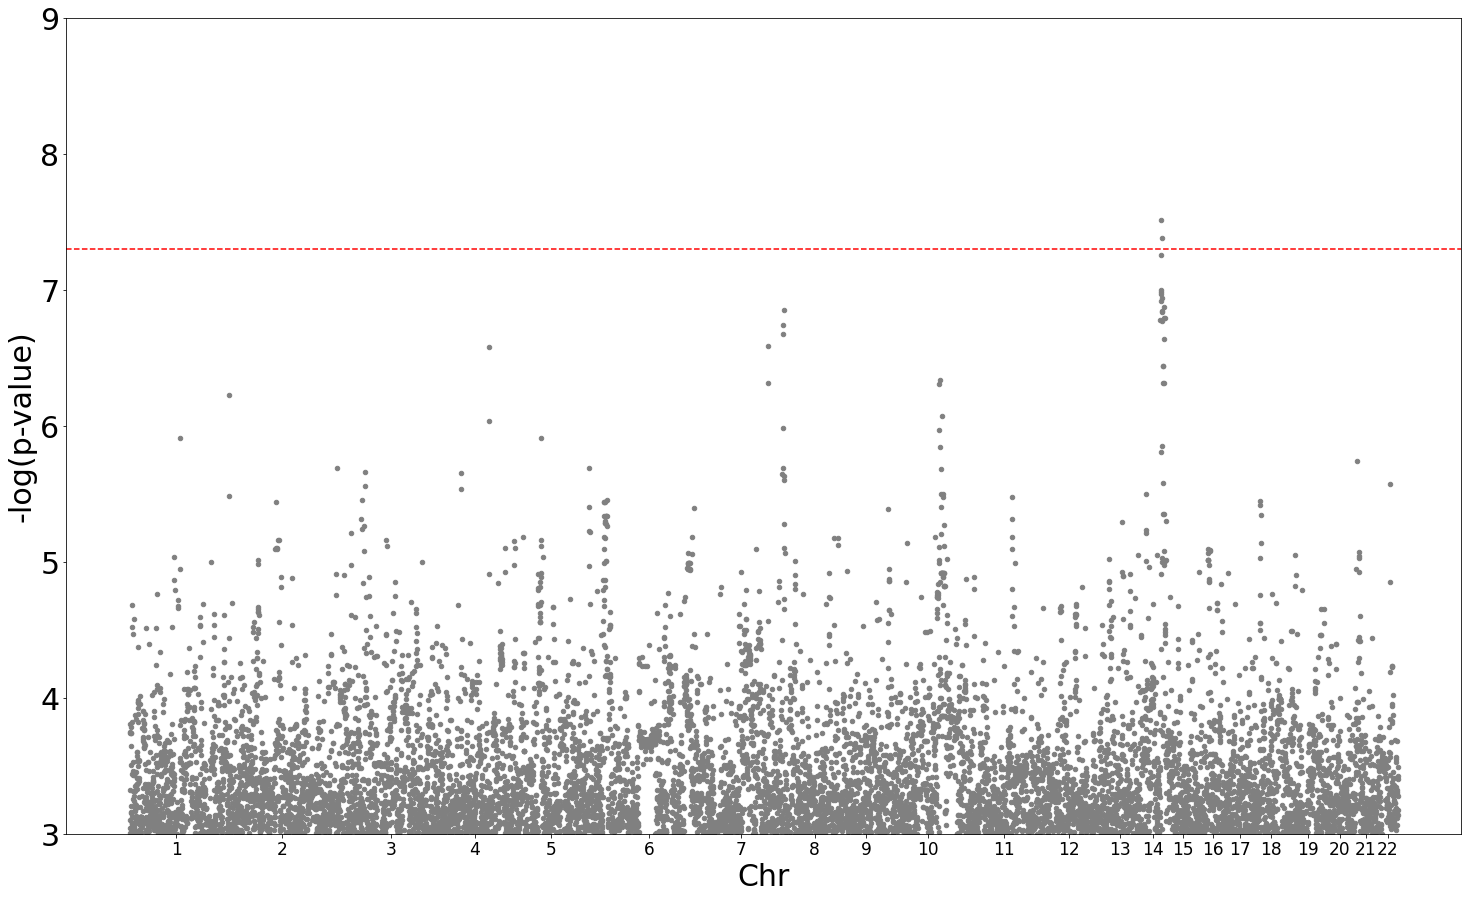

In [22]:
manhattanplot(gwas_results_pacerint_nochip_df, 'fig3a_pacergwas_withoutchip.tif') #cov-adjusted during GWAS

In [23]:
! gsutil cp fig3a_pacergwas_withoutchip.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig3a_pacergwas_withoutchip.tif

Copying file://fig3a_pacergwas_withoutchip.tif [Content-Type=image/tiff]...
\ [1 files][128.8 MiB/128.8 MiB]                                                
Operation completed over 1 objects/128.8 MiB.                                    


In [24]:
gwas_results_pacerint_nochip_df.sort_values('-logp', ascending = False).head(30)

,CHR,POS,SNPID,Allele1,Allele2,AC_Allele2,AF_Allele2,imputationInfo,N,BETA,SE,Tstat,p.value,varT,varTstar,ind,-logp
21830,14,95713905,rs1122138,C,A,2713,0.212584,1,6381,-0.105234,0.019004,-291.394880,3.067148e-08,2769.025499,2008.409111,9810,7.513265
21846,14,95737725,rs28567779,G,A,2821,0.221047,1,6381,-0.102440,0.018677,-293.656197,4.141583e-08,2866.630287,2079.203095,9826,7.382834
21829,14,95711986,rs2296312,T,C,2726,0.213603,1,6381,-0.103013,0.018954,-286.728253,5.486525e-08,2783.412980,2018.844533,9809,7.260703
21835,14,95715245,rs1984968,A,G,2722,0.213289,1,6381,-0.101024,0.018968,-280.799314,1.003317e-07,2779.520206,2016.021054,9815,6.998562
21833,14,95715023,rs1957937,A,T,2723,0.213368,1,6381,-0.100918,0.018966,-280.554538,1.031935e-07,2780.012028,2016.377779,9813,6.986348
21832,14,95714358,rs2887399,G,T,3374,0.264379,1,6381,-0.092574,0.017418,-305.134241,1.067570e-07,3296.121002,2390.718126,9812,6.971604
21845,14,95735518,rs10438223,G,A,2743,0.214935,1,6381,-0.099777,0.018815,-281.845489,1.139287e-07,2824.766446,2048.838723,9825,6.943367
21836,14,95715635,rs1984967,C,T,2721,0.213211,1,6381,-0.100428,0.018969,-279.101321,1.194740e-07,2779.117473,2015.728947,9816,6.922727
21859,14,95753488,rs2887453,G,A,2300,0.180223,1,6381,-0.106878,0.020260,-260.376928,1.325619e-07,2436.216383,1767.018463,9838,6.877581
13875,8,4186988,rs183727738,A,T,237,0.018571,1,6381,-0.297226,0.056450,-93.273526,1.399626e-07,313.813026,227.612545,6222,6.853988


# Comparing GWAS hits

Did not work well with GWAS catalog data due to lack of overlap of SNPs

In [25]:
def annotate(data, **kws):
    r, p = pearsonr(data['x'], data['y'])
    ax = plt.gca()
    ax.text(.05, .8, 'Pearson\'s R={:.2f}'.format(r),
            transform=ax.transAxes)

def compare_gwas_hits(our_df, other_df, xlab, ylab):
    our_df = our_df[['SNPID', '-logp']]
    other_df = other_df[['SNPID', '-logp']]
    other_df_hits = set(other_df['SNPID'])
    print(str(len(other_df_hits)) + " hits for expanded clones")
    overlap_df = our_df[our_df['SNPID'].isin(other_df_hits)]
    print(str(len(overlap_df)) + " SNPs with p-values in both datasets")
    overlap_set = set(overlap_df['SNPID'])
    our_df = our_df[our_df['SNPID'].isin(overlap_set)]
    other_df = other_df[other_df['SNPID'].isin(overlap_set)]
    our_dict = pd.Series(our_df['-logp'].values,index=our_df['SNPID']).to_dict()
    other_dict = pd.Series(other_df['-logp'].values,index=other_df['SNPID']).to_dict()
    x = []
    y = []
    snps = []
    for snp in overlap_set:
        x.append(our_dict[snp])
        y.append(other_dict[snp])
        snps.append(snp)
    data = pd.DataFrame({'x': x,'y': y, 'snps': snps})
    if len(data) > 2:
        g = sns.lmplot('x','y', data=data, scatter_kws={'alpha':0.10})
        g.map_dataframe(annotate)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.show()
    return data

## Total passenger mutations with and without chip patients

12070 hits for expanded clones
7583 SNPs with p-values in both datasets


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


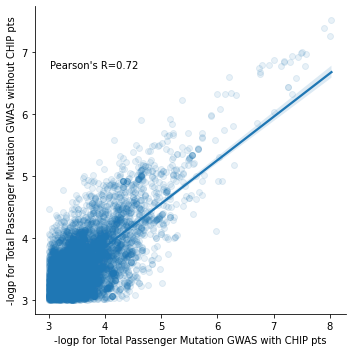

,x,y,snps
0,3.031885,3.029007,rs151336607
1,3.707666,3.457084,rs10788717
2,4.248982,4.543190,rs10132791
3,3.377066,3.412730,rs79503785
4,3.126054,3.438096,rs12081796
...,...,...,...
7578,4.534588,4.099419,rs7800640
7579,3.033174,3.017956,rs2272911
7580,3.388043,3.838274,rs10457030
7581,3.467513,3.153784,rs112054640


In [26]:
compare_gwas_hits(gwas_results_pacerint_df, gwas_results_pacerint_nochip_df, 
                  "-logp for Total Passenger Mutation GWAS with CHIP pts", 
                  "-logp for Total Passenger Mutation GWAS without CHIP pts")

## Zekavat et al

Our GWAS was for clonal expansion rate, Zekavat et al did a GWAS for expanded clones (clonal fraction > 10%) 
https://www.nature.com/articles/s41591-021-01371-0#Sec20

This section looks at their significant SNPs and plots our p-values for the same SNPs.

In [27]:
!gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_hits_mcasexpandedclones.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_hits_mcasexpandedclones.csv...
/ [1 files][  8.6 KiB/  8.6 KiB]                                                
Operation completed over 1 objects/8.6 KiB.                                      


In [28]:
# Importing and processing SNP df
gwas_results_expandedclone_df = pd.read_csv('gwas_hits_mcasexpandedclones.csv')
gwas_results_expandedclone_df.rename(columns={"rsid": "SNPID", "P": "p.value"}, inplace=True)
gwas_results_expandedclone_df['-logp'] = -np.log(gwas_results_expandedclone_df['p.value'])

In [29]:
compare_gwas_hits(gwas_results_pacerint_df, gwas_results_expandedclone_df,
                   "-logp for Total Passenger Mutation GWAS", "-logp for PACER GWAS")

63 hits for expanded clones
2 SNPs with p-values in both datasets


,x,y,snps
0,3.626723,27.649185,rs2853677
1,7.573684,170.856512,rs2887399


In [30]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_summary_stats_mcasexpandedclones.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas_summary_stats_mcasexpandedclones.csv...
| [1 files][753.7 MiB/753.7 MiB]   36.2 MiB/s                                   
Operation completed over 1 objects/753.7 MiB.                                    


In [31]:
# Importing and processing SNP df
gwas_summarystats_expandedclone_df = pd.read_csv('gwas_summary_stats_mcasexpandedclones.csv', sep ='\t')
gwas_summarystats_expandedclone_df.rename(columns={"rsid": "SNPID", "neg_log_pvalue": "-logp"}, inplace=True)

In [32]:
def compare_gwas_hits_expandedclone(our_df, other_df):
    our_df = our_df[['SNPID', '-logp']]
    other_df = other_df[['SNPID', '-logp']]
    other_df_hits = set(other_df['SNPID'])
    overlap_df = our_df[our_df['SNPID'].isin(other_df_hits)]
    overlap_set = set(overlap_df['SNPID'])
    our_df = our_df[our_df['SNPID'].isin(overlap_set)]
    other_df_sig = other_df[other_df['-logp'] > -np.log10(10e-5)]
    return set(other_df_sig['SNPID'])

In [33]:
def manhattanplot_comp(df, filename):
    fig = plt.figure(figsize=(25, 15)) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['darkred','darkgreen','darkblue', 'gold']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(df.groupby('#chrom')):
        group.plot(kind='scatter', x='ind', y='-logp',color=group['Significant in PACER GWAS'], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels, fontsize=17)

    # set axis limits
    # ax.set_xlim([0, len(df)])
#     ax.set_ylim([3, 9])
    ax.tick_params(axis='y', which='major', labelsize=12)
    plt.axhline(-np.log10(5e-8), ls='--', c='red')

    # x axis label
    ax.set_xlabel('Chr', fontsize = 30)
    ax.set_ylabel('-log(p-value)', fontsize=30)
    ax.tick_params(axis='y', which='major', labelsize=30)

    plt.savefig(filename, dpi=300)

    # show the graph
    plt.show()

In [34]:
gwas_summarystats_expandedclone_df['Significant in PACER GWAS'] = 'gray'
gwas_summarystats_expandedclone_df.loc[gwas_summarystats_expandedclone_df['SNPID'].isin(compare_gwas_hits_expandedclone(gwas_summarystats_expandedclone_df, gwas_results_pacerint_nochip_df)),'Significant in PACER GWAS'] = 'red'

In [35]:
gwas_summarystats_expandedclone_df['ind'] = range(len(gwas_summarystats_expandedclone_df))

In [36]:
gwas_summarystats_expandedclone_df

,#chrom,pos,SNPID,ref,alt,-logp,beta,stderr_beta,alt_allele_freq,Significant in PACER GWAS,ind
0,1,14933,rs199856693,G,A,0.234577,0.028401,0.051687,0.019737,gray,0
1,1,16949,rs199745162,A,C,0.022738,0.004940,0.077216,0.009020,gray,1
2,1,18849,rs533090414,C,G,0.491188,-0.054808,0.055423,0.983530,gray,2
3,1,47159,rs540662756,T,C,0.579302,0.047542,0.042514,0.029158,gray,3
4,1,52238,rs2691277,T,G,0.132315,0.028551,0.085141,0.992570,gray,4
...,...,...,...,...,...,...,...,...,...,...,...
10829219,22,51237063,rs3896457,T,C,0.092358,-0.003857,0.015910,0.296310,gray,10829219
10829220,22,51237364,rs200607599,A,G,0.133872,-0.026700,0.078801,0.008748,gray,10829220
10829221,22,51237712,rs370652263,G,A,0.385461,-0.026634,0.032442,0.053645,gray,10829221
10829222,22,51240820,rs5770837,C,T,0.556127,-0.065399,0.060271,0.015470,gray,10829222


In [53]:
gwas_summarystats_expandedclone_df[(gwas_summarystats_expandedclone_df['Significant in PACER GWAS'] == 'red') & (gwas_summarystats_expandedclone_df['#chrom'] == 21)]

,#chrom,pos,SNPID,ref,alt,-logp,beta,stderr_beta,alt_allele_freq,Significant in PACER GWAS,ind
10536396,21,15915506,rs13048538,A,G,0.419360,-0.014929,0.017032,0.240020,red,10536396
10538225,21,16339172,rs2229742,G,C,7.077269,0.122790,0.022912,0.103560,red,10538225
10538276,21,16353809,rs17274750,A,C,4.788052,0.102130,0.023693,0.097409,red,10538276
10538337,21,16380025,rs2823004,G,A,3.755031,0.067158,0.017902,0.198140,red,10538337
10538345,21,16383608,rs62220718,T,A,3.430334,0.063769,0.017914,0.198230,red,10538345
10538416,21,16413392,rs12627409,T,C,3.261148,0.060409,0.017479,0.212640,red,10538416
10538417,21,16413533,rs12627439,T,C,3.306783,0.060903,0.017479,0.212310,red,10538417
10538419,21,16413682,rs2823018,A,G,3.301491,0.060847,0.017479,0.212320,red,10538419
10538423,21,16414902,rs73172398,C,T,3.340160,0.061261,0.017479,0.212170,red,10538423
10538428,21,16416811,rs2823021,G,A,3.299504,0.061447,0.017658,0.208710,red,10538428


KeyboardInterrupt: 

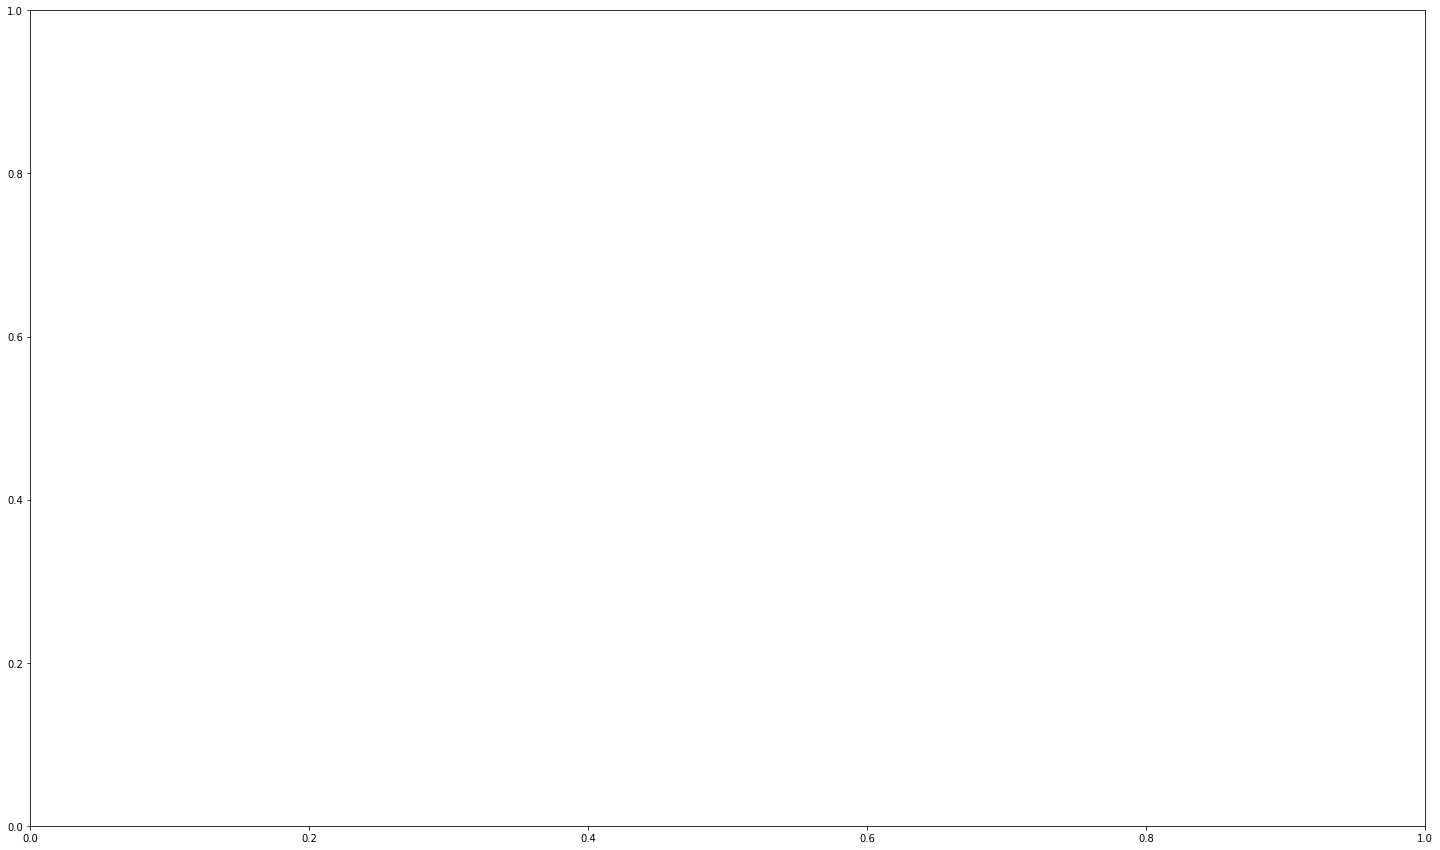

In [50]:
manhattanplot_comp(gwas_summarystats_expandedclone_df, 'fig3b_superimposedgwasresults.tif')

In [115]:
! gsutil cp fig3b_superimposedgwasresults.tif gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/figures/fig3b_superimposedgwasresults.tif

Copying file://fig3b_superimposedgwasresults.tif [Content-Type=image/tiff]...
\ [1 files][128.8 MiB/128.8 MiB]                                                
Operation completed over 1 objects/128.8 MiB.                                    


In [ ]:
gwas_summarystats_expandedclone_df

In [ ]:
logp_data = compare_gwas_hits(gwas_results_totpassmut_nochip_df, gwas_summarystats_expandedclone_df,
                   "-logp for Total Passenger Mutation GWAS", "-logp for Expanded Clone GWAS")

In [ ]:
logp_data[logp_data['x']>14]

In [ ]:
pass_not_clone_df = logp_data[(logp_data['x'] > 10) & (logp_data['y'] < 10)]
# pass_not_clone_df['gene'] = ['CSMD1', 'ALKBH5', 'NRIP1', '', '', 
#                              'SHMT1', 'SORCS3', '', '', 'IMMP2L', 
#                              'CSMD1', 'ZFPM2-AS1', '', 'SORCS3', 'SGCZ', 'FLII', 'CSMD1']

In [ ]:
for i in list(logp_data.loc[logp_data['x'] > 10, 'snps']):
    print(i)

In [ ]:
clone_not_pass_df = logp_data[(logp_data['x'] < 10) & (logp_data['y'] > 14)]
clone_not_pass_df['gene'] = ['', '', '', '', '', '', '', '', '', '', '', 'TCL1A', '', '', '', '', '']

## Coronary Artery Disease from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_1000883-withChildTraits.tsv .

In [ ]:
# gwas_results_cad_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_1000883-withChildTraits.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_cad_df.columns
# gwas_results_cad_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_cad_df['-logp'] = -np.log(gwas_results_cad_df['p.value'])

In [ ]:
# compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_cad_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for Coronary Artery Disease")

## CLL from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_0000095.tsv .

In [ ]:
# gwas_results_cll_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_0000095.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_cll_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_cll_df['-logp'] = -np.log(gwas_results_cll_df['p.value'])

In [ ]:
# compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_cll_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for Chronic Lymphocytic Leukemia")

## Mosaic loss of Y from GWAS Catalog

In [ ]:
# ! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/gwas_results/gwas-association-downloaded_2022-08-08-EFO_0007783.tsv .

In [ ]:
# gwas_results_mloy_df = pd.read_csv('gwas-association-downloaded_2022-08-08-EFO_0007783.tsv',
#             sep='\t', on_bad_lines='skip')

In [ ]:
# gwas_results_mloy_df.rename(columns={"SNPS": "SNPID", "P-VALUE": "p.value"}, inplace=True)
# gwas_results_mloy_df['-logp'] = -np.log(gwas_results_mloy_df['p.value'])

In [ ]:
compare_gwas_hits(gwas_results_totpassmut_df, gwas_results_mloy_df,
#                    "-logp for Total Passenger Mutation GWAS", "-logp for mLOY")